# Creating Synthetic Data

In [3]:
using Distributions, DataFrames, CSV, Plots

# define Gaussian plume model
function gaussian_plume(x, y, z, Q, u, sigma_y, sigma_z, H)
    t1 = Q / (2 * π * u * sigma_y * sigma_z)
    t2 = exp(-y^2 / (2 * sigma_y^2))
    t3 = exp(-((z - H)^2) / (2 * sigma_z^2)) + exp(-((z + H)^2) / (2 * sigma_z^2))
    concentration = t1 * t2 * t3
    return concentration
end

gaussian_plume (generic function with 1 method)

In [4]:
using Random
# generate synthetic data that gives location (x, y, z) and concentration (ppm) for training
Random.seed!(42)

function generate_synthetic_data(Q, u, H, num_points=1000, noise=0.1)
    
    xs = rand(Uniform(-50, 50), num_points)
    ys = rand(Uniform(-50, 50), num_points)
    zs = rand(Uniform(0, 50), num_points)
    sigma_y = 10.0
    sigma_z = 5.0

    raw_data = [(x, y, z, gaussian_plume(x, y, z, Q, u, sigma_y, sigma_z, H)) for (x, y, z) in zip(xs, ys, zs)]
    
    # add Gaussian noise
    noisy_data = [(x, y, z, concentration + rand(Normal(0, noise))) for (x, y, z, concentration) in raw_data]
    
    return noisy_data
end

synthetic_data = generate_synthetic_data(10.0, 5.0, 10.0)

df = DataFrame(x=[pt[1] for pt in synthetic_data],
               y=[pt[2] for pt in synthetic_data],
               z=[pt[3] for pt in synthetic_data],
               concentration=[pt[4] for pt in synthetic_data])

# save synthetic data
CSV.write("synthetic_gaussian_plume_data.csv", df)

"synthetic_gaussian_plume_data.csv"

In [5]:
synthetic_data
# FORMAT: x, y, z, concentration

1000-element Vector{NTuple{4, Float64}}:
 (-32.64254242054926, -7.774154496841575, 27.657879712868844, 0.0004378633616200531)
 (-17.833838084219344, 23.782744274458096, 41.23129873103324, 0.10262706957238862)
 (-24.141453004684543, -39.91654175139898, 15.726590491303549, -0.11165725776308447)
 (-33.35613559143346, -17.893427027893182, 45.92662244745052, -0.030137207108302522)
 (2.7015007108901585, 46.95150609084499, 36.62534384293336, 0.022759237809306165)
 (-1.697786303154814, -48.71016982441384, 17.815211221347887, 0.22573512241672264)
 (-10.933661091350835, 25.55027304121053, 32.6032000131564, 0.05003067300263081)
 (30.276255127997302, -15.32584270820987, 13.517166564074623, -0.06552032180652549)
 (48.07576556964709, 2.932283386211445, 45.377588419630186, 0.07137770813882452)
 (-40.55685514285838, 29.280719287583565, 4.965836233846499, 0.12546874004231887)
 ⋮
 (-18.906277868374787, -21.610094090482377, 8.708324835905145, 0.011551305988063119)
 (-49.4306396279244, -38.93933966118092,

# Training PINN on Gaussian Plume Dispersion

In [6]:
using NeuralPDE, Lux, DomainSets, Optimization, OptimizationOptimisers
import ModelingToolkit: Interval, infimum, supremum
# defining the Gaussian equation
@parameters x y z # location in space at x, y, z
@syms C(x, y, z) # concentration of gas or PM at x, y, z (lat, long, alt) location
Dxx = Differential(x)^2
Dyy = Differential(y)^2
Dzz = Differential(z)^2

# define PDE with variables
Q = 10.0 # source emission rate, g/s (CHANGE FOR REAL)
u = 5.0 # horizontal wind velocity along plume centerline, m/s (CHANGE FOR REAL)
H = 10.0 # height of plume centerline above ground level, m (CHANGE FOR REAL)
sigma_y = 10.0 # vertical standard deviation of emission distribution, m (CHANGE FOR REAL)
sigma_z = 5.0 # horizontal standard deviation of emission distribution, m  (CHANGE FOR REAL)

gauss_eq = (Dxx(C(x, y, z)) + Dyy(C(x, y, z)) + Dzz(C(x, y, z)) ~ (Q / (2 * π * u * sigma_y * sigma_z)) * exp(-y^2 / (2 * sigma_y^2)) * (exp(-(z - H)^2 / (2 * sigma_z^2)) + exp(-(z + H)^2 / (2 * sigma_z^2))))

Differential(z)(Differential(z)(C(x, y, z))) + Differential(x)(Differential(x)(C(x, y, z))) + Differential(y)(Differential(y)(C(x, y, z))) ~ 0.006366197723675813(exp(-0.02((-10.0 + z)^2)) + exp(-0.02((10.0 + z)^2)))*exp(-0.005(y^2))

In [7]:
@variables I_y I_z x
@syms J_y(..) K_y(..) J_z(..) K_z(..)

sigma_y_eq = exp(I_y + J_y(log(x)) + K_y(log(x))^2) 

exp(I_y + J_y(log(x)) + K_y(log(x))^2)

In [8]:
sigma_z_eq = exp(I_z + J_z(log(x)) + K_z(log(x))^2)

exp(I_z + J_z(log(x)) + K_z(log(x))^2)

In [9]:
# boundary conditions
bcs = [C(0, y, z) ~ gaussian_plume(0, y, z, Q, u, sigma_y, sigma_z, H)]

# space and time domains
domains = [x ∈ Interval(-50.0, 50.0),
           y ∈ Interval(-50.0, 50.0),
           z ∈ Interval(0.0, 100.0)]

3-element Vector{Symbolics.VarDomainPairing}:
 Symbolics.VarDomainPairing(x, -50.0 .. 50.0)
 Symbolics.VarDomainPairing(y, -50.0 .. 50.0)
 Symbolics.VarDomainPairing(z, 0.0 .. 100.0)

In [10]:
# define PINN, 3 dim
dim = 3
chain = Lux.Chain(Lux.Dense(dim, 16, Lux.σ), 
                  Lux.Dense(16, 16, Lux.σ), 
                  Lux.Dense(16, 1))

@named pde_system = PDESystem(gauss_eq, 
                              bcs, 
                              domains, 
                              [x, y, z], 
                              [C(x, y, z)])
                              
discretization = PhysicsInformedNN(chain, QuadratureTraining())
prob = discretize(pde_system, discretization)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [0.5325376987457275 -0.21818970143795013 0.19764332473278046; 0.33774808049201965 0.3089984357357025 0.042451657354831696; … ; 0.38329413533210754 -0.2412206083536148 0.18066488206386566; -0.041122112423181534 -0.15707367658615112 0.3216385543346405], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.18884706497192383 0.16615962982177734 … -0.04437965527176857 0.37738415598869324; 0.06474185734987259 -0.11161636561155319 … 0.07775875926017761 0.41948744654655457; … ; -0.19996803998947144 -0.3635158836841583 … -0.216283917427063 0.08221777528524399; -0.06266733258962631 0.1980009377002716 … -0.3010784089565277 0.20011045038700104], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [-0.37769615650177 -0.19233256578445435 … 0.11829182505607605 0.2970147430896759], bias = [0.0;;]))

Current loss: 0.0807088259222022
Current loss: 3.495476449172509
Current loss: 0.43322206421780046
Current loss: 0.36695889001622023
Current loss: 1.184861761585393
Current loss: 0.9172749373416073
Current loss: 0.38895518023094533
Current loss: 0.0729411173386107
Current loss: 0.005696344693821105
Current loss: 0.07617966740829106
Current loss: 0.17123981533213695
Current loss: 0.2242967228478471
Current loss: 0.21858128296116927
Current loss: 0.16982822272812279
Current loss: 0.10556875566510894
Current loss: 0.04929319555679431
Current loss: 0.014060251776095413
Current loss: 0.0023762910746245786
Current loss: 0.009434687307694086
Current loss: 0.026575075678867528
Current loss: 0.04445130863569732
Current loss: 0.05640146170628776
Current loss: 0.05913999952188385
Current loss: 0.05318354183377922
Current loss: 0.0414096155676113
Current loss: 0.027692129589446304
Current loss: 0.015237407486140522
Current loss: 0.006344101093008257
Current loss: 0.001706992131196721
Current loss:

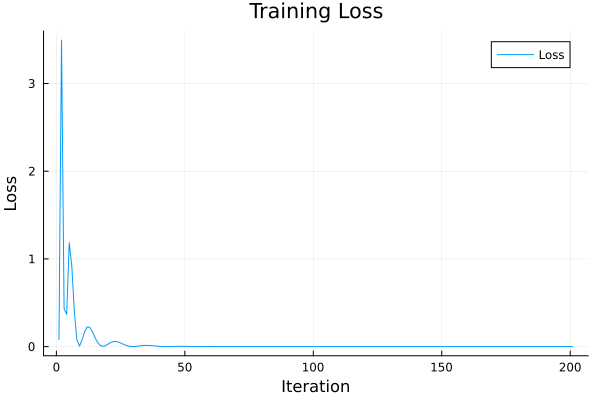

"loss_history.csv"

In [11]:
using OptimizationOptimisers: ADAM

# store loss history
loss_history = Float64[]

callback = function (p, l)
    global loss_history
    push!(loss_history, l)
    println("Current loss: $l")
    return false
end

# 200 iterations is sufficient, use ADAM optimizer
res = Optimization.solve(prob, 
                         ADAM(0.1); callback=callback, 
                         maxiters=200)

display(plot(loss_history, 
           title="Training Loss", 
           xlabel="Iteration", 
           ylabel="Loss", 
           label="Loss"))

# save loss history
loss_df = DataFrame(iteration=1:length(loss_history), loss=loss_history)
CSV.write("loss_history.csv", loss_df)

In [12]:
# save model
model = discretization.phi

NeuralPDE.Phi{Chain{@NamedTuple{layer_1::Dense{true, typeof(sigmoid_fast), typeof(glorot_uniform), typeof(zeros32)}, layer_2::Dense{true, typeof(sigmoid_fast), typeof(glorot_uniform), typeof(zeros32)}, layer_3::Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}}, Nothing}, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}(Chain{@NamedTuple{layer_1::Dense{true, typeof(sigmoid_fast), typeof(glorot_uniform), typeof(zeros32)}, layer_2::Dense{true, typeof(sigmoid_fast), typeof(glorot_uniform), typeof(zeros32)}, layer_3::Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}}, Nothing}((layer_1 = Dense(3 => 16, sigmoid_fast), layer_2 = Dense(16 => 16, sigmoid_fast), layer_3 = Dense(16 => 1)), nothing), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

# Example Scenario

In [13]:
using GasDispersion

# creating example scenario
function create_scenario()
    co2 = Substance(name="carbon dioxide", # CO2 as example but could be any other gas
                    molar_weight=0.04401, # kg/mol
                    liquid_density=771.0, # kg/m³
                    k=1.30,
                    boiling_temp=194.7, # K
                    latent_heat=325000, # J/kg
                    gas_heat_capacity=846, # J/kg/K
                    liquid_heat_capacity=1800)

    atm_pressure = 1
    init_pressure = 4e5 + atm_pressure
    init_temp = 25 + 273.15

    scenario = scenario_builder(co2, JetSource; 
                                phase=:gas,
                                diameter=0.01, # m
                                dischargecoef=0.32,
                                temperature=init_temp, # K
                                pressure=init_pressure, # atm
                                height=4) # m, height of hole above the ground
end

create_scenario (generic function with 1 method)

In [14]:
scenario = create_scenario()

Substance: carbon dioxide 
    MW: 0.04401 kg/mol 
    P_v: GasDispersion.Antoine{Float64}(8.835570427657274, 1720.2855622648713, 0.0) Pa 
    ρ_g: 1.8612948341167193 kg/m^3 
    ρ_l: 771.0 kg/m^3 
    T_ref: 288.15 K 
    P_ref: 101325.0 Pa 
    k: 1.3  
    T_b: 194.7 K 
    Δh_v: 325000 J/kg 
    Cp_g: 846 J/kg/K 
    Cp_l: 1800 J/kg/K 
HorizontalJet release:
    ṁ: 0.028264333128029027 kg/s 
    Δt: Inf s 
    d: 0.01 m 
    u: 80.74795817289746 m/s 
    h: 4.0 m 
    P: 218291.6392533598 Pa 
    T: 259.2608695652174 K 
    f_l: 0.0  
SimpleAtmosphere atmosphere:
    P: 101325.0 Pa 
    T: 298.15 K 
    u: 1.5 m/s 
    h: 10.0 m 
    rh: 0.0 % 
    stability: ClassF  


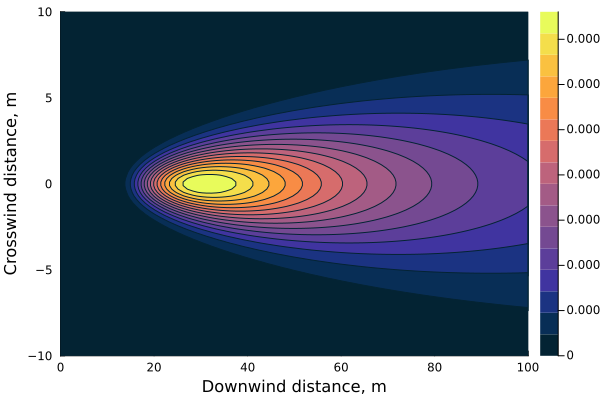

In [15]:
# visualize scenario (Gaussian Plume)
scenario_g_plume = plume(scenario, GaussianPlume)
plot(scenario_g_plume, xlims=(0, 100), ylims=(-10, 10), height=3)

# Predicting Concentration Values in Scenario

In [16]:
Random.seed!(42)

# Create data points within scenario range
xs_real = rand(Uniform(0, 100), 100)
ys_real = rand(Uniform(-10, 10), 100)
zs_real = rand(Uniform(0, 5), 100)

data = [(x, y, z) for (x, y, z) in zip(xs_real, ys_real, zs_real)]

100-element Vector{Tuple{Float64, Float64, Float64}}:
 (17.35745757945074, 9.390301218168997, 0.1393606241598544)
 (32.166161915780656, -9.742033964882769, 4.962174901022017)
 (25.858546995315457, 5.1100546082421054, 0.661506295134921)
 (16.643864408566543, -3.065168541641974, 4.047126729330078)
 (52.70150071089016, -2.806119432505307, 1.1070443778416368)
 (48.302213696845186, -4.79624650438899, 0.5859091691169699)
 (39.066338908649165, 9.04516139993656, 0.5494547670598027)
 (80.2762551279973, -8.739104981532076, 1.8192203717251765)
 (98.07576556964709, -6.2181996754688384, 0.03438663393907193)
 (9.443144857141617, -6.013011413602607, 4.066883553550571)
 ⋮
 (0.07152547045022883, 6.965651395282613, 0.7307229412611438)
 (95.62798124437134, -7.84530243662722, 4.6437984591050245)
 (19.80796809083789, -3.5620035601927764, 4.11452476911222)
 (90.23205203170956, -7.467558305136592, 2.028660275205192)
 (62.44472854568323, -4.294106910514078, 3.593325559306627)
 (72.19827350406844, -6.109786899

In [17]:
# Get actual values with scenario
function get_values(data)
    concentrations = []
    for dp in data
        push!(concentrations, scenario_g_plume(dp[1], dp[2], dp[3]))
    end
    return concentrations
end

real_concentrations = Array{Float64}(get_values(data))

100-element Vector{Float64}:
 2.1861708729435635e-48
 1.3503590495712888e-12
 1.9280742449088047e-13
 9.315900808378111e-6
 2.4130685437516104e-5
 9.527871156104594e-7
 5.7176668459931626e-12
 7.189261522257172e-6
 3.007797672311933e-5
 8.417100697044518e-33
 ⋮
 0.0
 3.565058401734401e-5
 6.9962651355795184e-6
 2.6631565045939078e-5
 0.0001504879235063308
 5.5139076443980095e-5
 2.0293045451587931e-10
 0.0
 4.1385360010479183e-38

In [18]:
# predict concentration values with PINN model
predicted_concentrations = [first(model([x, y, z], res.u)) for (x, y, z) in data]

100-element Vector{Float64}:
  0.008304839425885271
  0.004761645000670625
  0.008830503514804616
  0.013673502732065967
  0.007365924052650578
  0.007251185172765134
  0.00773302401301257
  0.0073668180517736884
  0.007374002767083781
  0.010932584398237213
  ⋮
 -0.00228094189591288
  0.007376563710740898
  0.012771022326278934
  0.007373617188320301
  0.007472274256861155
  0.007383863037281394
  0.010761898226862507
  0.004076054671323178
  0.016991780528601157